In [1]:
# NOTE: reduced implementation might require slightly different parameters for same results

## Notebook Config

In [74]:
# Imports
import gc
import os
import sys
import h5py
import random
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [2]:
epochs = [1, 3, 5, 6, 7, 8, 10, 12, 14, 17, 21, 24, 34, 38, 41, 45, 49, 53, 72, 80, 85, 91, 99, 109, 119, 128, 140, 161, 169, 173, 180, 196, 230, 250, 282, 295, 304, 324, 345, 376, 396, 424, 463, 499, 553, 577, 597, 615, 650, 693, 722, 750, 757, 763, 782, 800, 821, 866]

In [3]:
# Relative Imports
package_path = Path(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
sys.path.insert(0, str(package_path))

from src.expressive_leaky_memory_neuron_initialization import ELM
from src.expressive_leaky_memory_neuron_forget import ELMf
from src.neuronio.neuronio_data_utils import (
    NEURONIO_DATA_DIM, 
    NEURONIO_LABEL_DIM, 
    get_data_files_from_folder, 
    parse_sim_experiment_file,
    visualize_training_batch,
)
from src.neuronio.neuronio_data_loader_filtered import NeuronIO
from src.neuronio.neuronio_train_utils import NeuronioLoss
from src.neuronio.neuronio_eval_utils import (
    NeuronioEvaluator, 
    compute_test_predictions_multiple_sim_files, 
    filter_and_extract_core_results,
)

In [4]:
# General Config
general_config = dict()
general_config["seed"] = 0
general_config["device"] = 'cuda' if torch.cuda.is_available() else 'cpu'
general_config["short_training_run"] = True # TODO: change to full length run
general_config["verbose"] = True #general_config["short_training_run"]
torch_device = torch.device(general_config["device"])
print("Torch Device: ", torch_device)

Torch Device:  cuda


In [5]:
# Seeding & Determinism
os.environ['PYTHONHASHSEED'] = str(general_config["seed"])
random.seed(general_config["seed"])
np.random.seed(general_config["seed"])
torch.manual_seed(general_config["seed"])
torch.cuda.manual_seed(general_config["seed"])
torch.backends.cudnn.deterministic = True

## Data, Model, Training Config

In [6]:
# NOTE: this step requires you having downloaded the dataset

# Download Train Data: 
# https://www.kaggle.com/datasets/selfishgene/single-neurons-as-deep-nets-nmda-train-data
# Download Test Data: 
# https://www.kaggle.com/datasets/selfishgene/single-neurons-as-deep-nets-nmda-test-data # Data_test

# Location of downloaded folders
data_dir_path = Path("D:/NeuronIO").expanduser().resolve() # TODO: change to neuronio data path
train_data_dir_path = data_dir_path / "train"  # TODO: change to train subfolder
test_data_dir_path = data_dir_path / "test/Data_test"  # TODO: change to test subfolder

In [7]:
# Data Config

data_config = dict()
train_data_dirs = [
    str(train_data_dir_path / "full_ergodic_train_batch_2"),
    #str(train_data_dir_path / "full_ergodic_train_batch_3"),
    #str(train_data_dir_path / "full_ergodic_train_batch_4"),
    #str(train_data_dir_path / "full_ergodic_train_batch_5"),
    #str(train_data_dir_path / "full_ergodic_train_batch_6"),
    #str(train_data_dir_path / "full_ergodic_train_batch_7"),
    #str(train_data_dir_path / "full_ergodic_train_batch_8"),
    #str(train_data_dir_path / "full_ergodic_train_batch_9"),
    #str(train_data_dir_path / "full_ergodic_train_batch_10"),
]
valid_data_dirs = [str(train_data_dir_path / "full_ergodic_train_batch_1")]
test_data_dirs = [str(test_data_dir_path)]

data_config["train_data_dirs"] = train_data_dirs
data_config["valid_data_dirs"] = valid_data_dirs
data_config["test_data_dirs"] = test_data_dirs

data_config["data_dim"] = NEURONIO_DATA_DIM 
data_config["label_dim"] = NEURONIO_LABEL_DIM

In [8]:
# Model Config

model_config = dict()
model_config["num_input"] = data_config["data_dim"]
model_config["num_output"] = 1
model_config["num_memory"] = 10
#model_config["mlp_hidden_size"] = 10
model_config["memory_tau_max"] = 150.0
model_config["num_branch"] = 45
model_config["num_synapse_per_branch"] = 100
model_config["input_to_synapse_routing"] = "neuronio_routing"

In [9]:
# Training Config

train_config = dict()
train_config['forget_gate'] = False
train_config["num_epochs"] = 5 if general_config["short_training_run"] else 30
train_config["learning_rate"] = 5e-4
train_config["batch_size"] = 8 if general_config["short_training_run"] else 8
train_config["batches_per_epoch"] = 1000 if general_config["short_training_run"] else 5000 #10000
train_config["batches_per_epoch"] = int(8/train_config["batch_size"] * train_config["batches_per_epoch"])
train_config["file_load_fraction"] = 0.5 if general_config["short_training_run"] else 0.3
train_config["num_prefetch_batch"] = 1
train_config["num_workers"] = 2 # will make run nondeterministic
train_config["burn_in_time"] = 150
train_config["input_window_size"] = 500
train_config["rest_start"] = True
train_config["sec_len"] = 200
train_config["start_save_path"] = '../data_processed/NeuronIOstartpoint/'
train_config["ignore_time_from_start"] = 400

## Data, Model, Training Setup

In [10]:
# Preparing Data Loaders

train_files = get_data_files_from_folder(data_config["train_data_dirs"])
valid_files = get_data_files_from_folder(data_config["valid_data_dirs"])
test_files = get_data_files_from_folder(data_config["test_data_dirs"])

train_data_loader = NeuronIO(
    file_paths=train_files,
    batches_per_epoch=train_config["batches_per_epoch"],
    batch_size=train_config["batch_size"],
    input_window_size=train_config["input_window_size"],
    num_workers=train_config["num_workers"],
    num_prefetch_batch=train_config["num_prefetch_batch"],
    file_load_fraction=train_config["file_load_fraction"],
    rest_start = train_config["rest_start"],
    sec_len = train_config["sec_len"],
    save_path = train_config["start_save_path"],
    seed=general_config["seed"],
    ignore_time_from_start = train_config["ignore_time_from_start"],
    device=torch_device,
)

train_evaluator = NeuronioEvaluator(
    test_file=train_files[0],
    burn_in_time=train_config["burn_in_time"],
    input_window_size=train_config["input_window_size"],
    device=torch_device,
)

valid_evaluator = NeuronioEvaluator(
    test_file=valid_files[0],
    burn_in_time=train_config["burn_in_time"],
    input_window_size=train_config["input_window_size"],
    device=torch_device,
)

In [11]:
# Initialize the ELM model
if train_config['forget_gate']:
    model = ELMf(**model_config).to(torch_device)
else:
    model = ELM(**model_config).to(torch_device)

# Initialize the loss function, optimizer, and scheduler
criterion= NeuronioLoss()
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=train_config["batches_per_epoch"] * train_config["num_epochs"]
)
init_optimizer = optim.Adam(model.w_y.parameters(), lr=1e2*train_config["learning_rate"])

In [12]:
# Visualize ELM model
print(model)

ELM(
  (mlp): RecursiveScriptModule(
    original_name=MLP
    (network): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=Linear)
    )
  )
  (w_y): RecursiveScriptModule(original_name=Linear)
)


In [13]:
model.state_dict()

OrderedDict([('_proto_w_s',
              tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000], device='cuda:0')),
             ('tau_b',
              tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
                      5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
                      5., 5., 5., 5., 5., 5., 5., 5., 5.], device='cuda:0')),
             ('_proto_tau_m',
              tensor([-18.8669,  -5.2933,  -4.2748,  -3.5129,  -2.8340,  -2.1766,  -1.4978,
                       -0.7359,   0.2827,  16.0943], device='cuda:0')),
             ('input_to_synapse_indices',
              tensor([   0,  639,    1,  ..., 1277, 1277, 1277], device='cuda:0')),
             ('valid_indices_mask',
              tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')),
             ('mlp.network.0.weight',
              tensor([[-0.0010,  0.0723, -0.1110,  ...,  0.0535,  0.0182,  0.0904],
                   

## Explore initialization

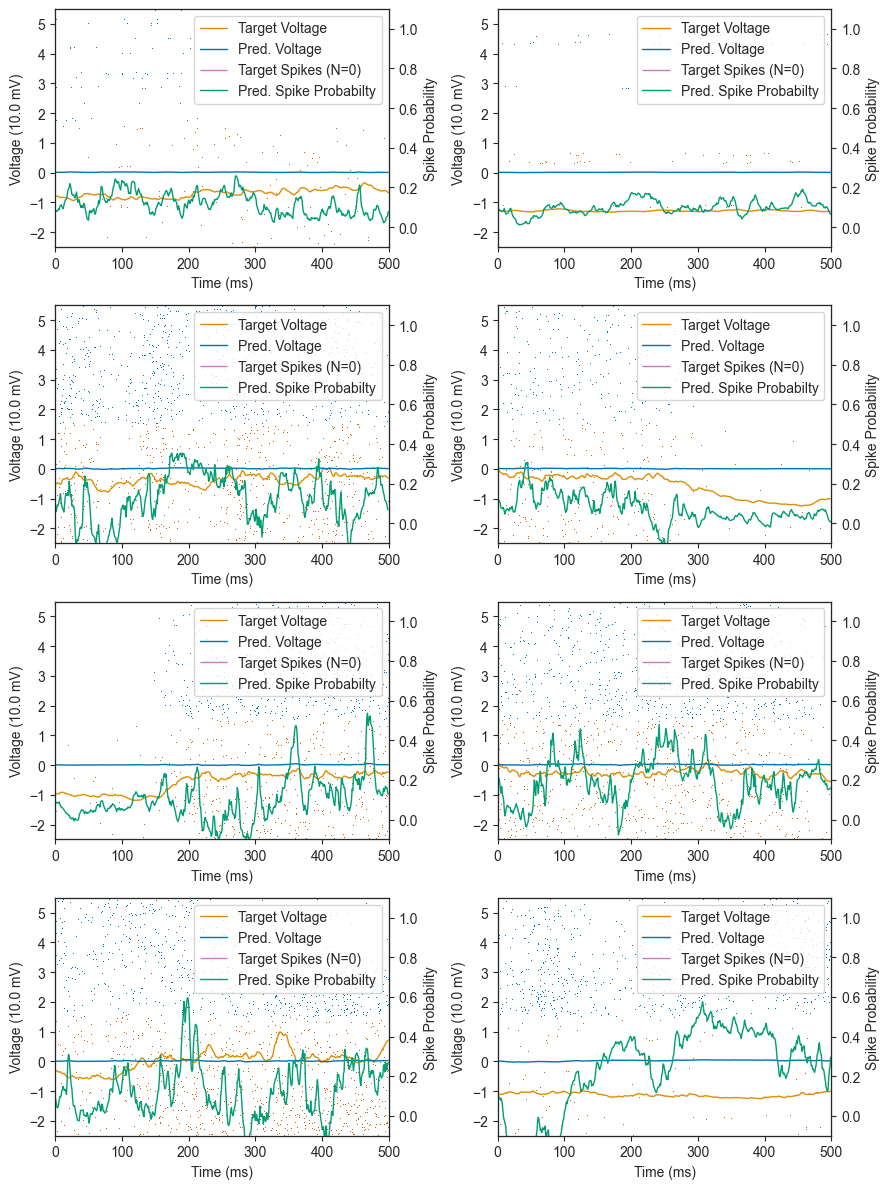

In [80]:
X_viz, (y_spike_viz, y_soma_viz) = next(iter(train_data_loader))
with torch.no_grad():
    #outputs = model.neuronio_eval_forward(X_viz)
    outputs = model(X_viz)
    visualize_training_batch(X_viz, y_spike_viz, y_soma_viz, outputs[..., 0], outputs[..., 0], num_viz=8)

In [15]:
print(outputs.shape)

torch.Size([8, 500, 1])


In [16]:
from scipy import signal
def filter_signal(
    x, fs: float, low: float, high: float, order: int = 3):
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.
    """
    y=[]
    #b, a = signal.butter(order, [low, high], "bandpass", fs=fs)
    b, a = signal.butter(order, high, "lowpass", fs=fs)
    for row in x:
        y.append(signal.filtfilt(b, a, row))
    return y

In [17]:
def extract_spikes(outputs, visualize=False):
    out = outputs.cpu().detach().numpy().squeeze(-1)
    xf = filter_signal(out, 1000.0, 1, 100, 3)
    target = np.array(out)
    for i, x in enumerate(out):
        peaks, _ = signal.find_peaks(x, prominence=0.06, distance=20, height=0.)
        target[i][peaks] = 1.0
        target[i][peaks+1] = 0.0
        target[i][peaks+2] = -0.5##reset
        if i==4 and visualize:
            plt.plot(x)
            plt.plot(target[i])
            plt.plot(peaks, x[peaks], "x")
            plt.plot(np.zeros_like(xf[1]), "--", color="gray")
            plt.show()
   
    return target


In [68]:
def ODE(outputs, tau=50, visualize=False):
    out = outputs.cpu().detach().numpy().squeeze(-1)
    LIF = np.zeros(out.shape)
    spikes = np.zeros(out.shape, dtype=int)
    for t in range(out.shape[1]):
        
        LIF[:, t] = (1-1/tau)*LIF[:, t-1] + out[:, t]
        s = LIF[:, t]>= 5.
        spikes[:, t] = s
        LIF[s, t] = -1
        #print(LIF[:, t])
        
    if visualize:
        i=0
        plt.plot(LIF[i], label = 'voltage')
        #plt.plot(out[i])
        plt.plot(spikes[i], label="spikes")
        plt.plot(np.zeros_like(out[i]), "--", color="gray")
        plt.legend()
        plt.show()
   
    return LIF, spikes

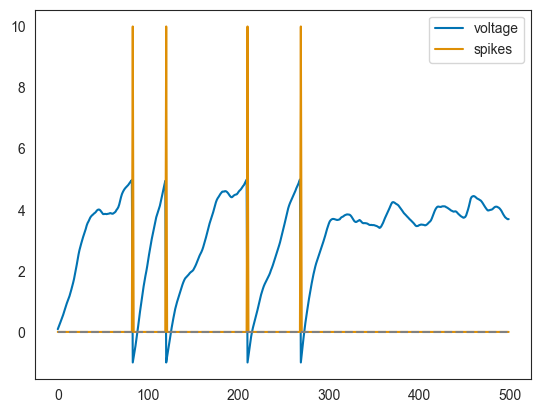

In [87]:
LIF, spikes = ODE(outputs, visualize=True)

In [91]:
spikes.max()

np.int64(1)

In [93]:
import seaborn as sns
DEFAULT_Y_TRAIN_SOMA_SCALE = 1 / 10
def visualize_LIF_batch(
    input_spikes,
    target_spikes,
    target_soma,
    pred_spikes=None,
    pred_soma=None,
    num_viz: int = None,
    save_fig_path: str = None,
    y_train_scale: float = DEFAULT_Y_TRAIN_SOMA_SCALE,
):
    input_spikes = input_spikes.cpu().numpy()
    target_spikes = target_spikes.cpu().numpy()
    target_soma = target_soma.cpu().numpy()
    # if pred_spikes is not None:
    #     pred_spikes = pred_spikes.cpu().numpy()
    # if pred_soma is not None:
    #     pred_soma = pred_soma.cpu().numpy()

    # apply train scale to predicitons
    if pred_soma is not None:
        pred_soma *= y_train_scale

    # general visualization settings
    color_palette = sns.color_palette("colorblind")
    sns.set_palette(color_palette)
    sns.set_style("white")

    # spike visualization settings
    levels = [-1.5, -0.5, 0.5, 1.5]
    colors = [color_palette[0], "white", color_palette[3]]
    cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

    # configure plot size
    num_viz = target_soma.shape[0] if num_viz is None else num_viz
    sequence_len = target_soma.shape[1]
    rows = num_viz // 2 + num_viz % 2
    columns = 2 if num_viz >= 2 else 1
    fig, axs = plt.subplots(
        nrows=rows, ncols=columns, figsize=(9 if num_viz >= 2 else 7.5, 3 * rows)
    )
    ax = axs.flatten() if num_viz >= 2 else [axs]

    for i in range(num_viz):
        lines = []
        legends = []

        # configure general grid
        ax[i].yaxis.set_visible(False)
        ax[i].set_xlabel("Time (ms)")
        ax[i].xaxis.grid(False)

        # plot input spikes
        ax1 = ax[i].twinx()
        ax1.imshow(
            input_spikes[i].T,
            cmap=cmap,
            origin="lower",
            norm=norm,
            interpolation="nearest",
            aspect="auto",
        )
        ax1.yaxis.set_visible(False)

        # configure voltage axis
        ax2 = ax[i].twinx()
        ax2.set_ylim(-2.5, 5.5)
        ax2.set_xlim(0, sequence_len)
        ax2.set_ylabel(f"Voltage ({1/y_train_scale} mV)")
        ax2.yaxis.tick_left()
        ax2.yaxis.set_label_position("left")

        # plot target voltage
        (line,) = ax2.plot(
            target_soma[i],
            label="Target Voltage",
            color=color_palette[1],
            linewidth=1.0,
        )
        lines.append(line)

        if pred_soma is not None:
            # plot pred soma
            (line,) = ax2.plot(
                pred_soma[i],
                label="Pred. Voltage",
                color=color_palette[0],
                linewidth=1.0,
            )
            lines.append(line)

        # plot target spikes
        nonzero_target_spikes = np.nonzero(target_spikes[i])
        if len(nonzero_target_spikes) > 0:
            line = ax2.vlines(
                x=nonzero_target_spikes,
                ymin=1.5,
                ymax=2.1,
                colors=color_palette[4],
                label=f"Target Spikes (N={int(sum(target_spikes[i]))})",
                linewidth=1.0,
            )
            lines.append(line)

        if pred_spikes is not None:
            # configure spikre prediction axis
            ax3 = ax[i].twinx()
            ax3.set_ylim(-0.1, 1.1)
            ax3.set_ylabel(f"Spike Probability")
            ax3.grid(False)

            # plot pred spikes
            (line,) = ax3.plot(
                pred_spikes[i],
                label="Pred. Spike Probabilty",
                color=color_palette[2],
                linewidth=1.0,
            )
            lines.append(line)

        # combine legends
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels)

        # set the border color to grey
        for spine in ax[i].spines.values():
            spine.set_edgecolor("grey")
        for spine in ax2.spines.values():
            spine.set_edgecolor("grey")

        # enable x axis spines
        ax[i].xaxis.set_ticks_position("bottom")

    fig.tight_layout()
    if save_fig_path is not None:
        fig.savefig(save_fig_path, dpi=300)
    else:
        plt.show()

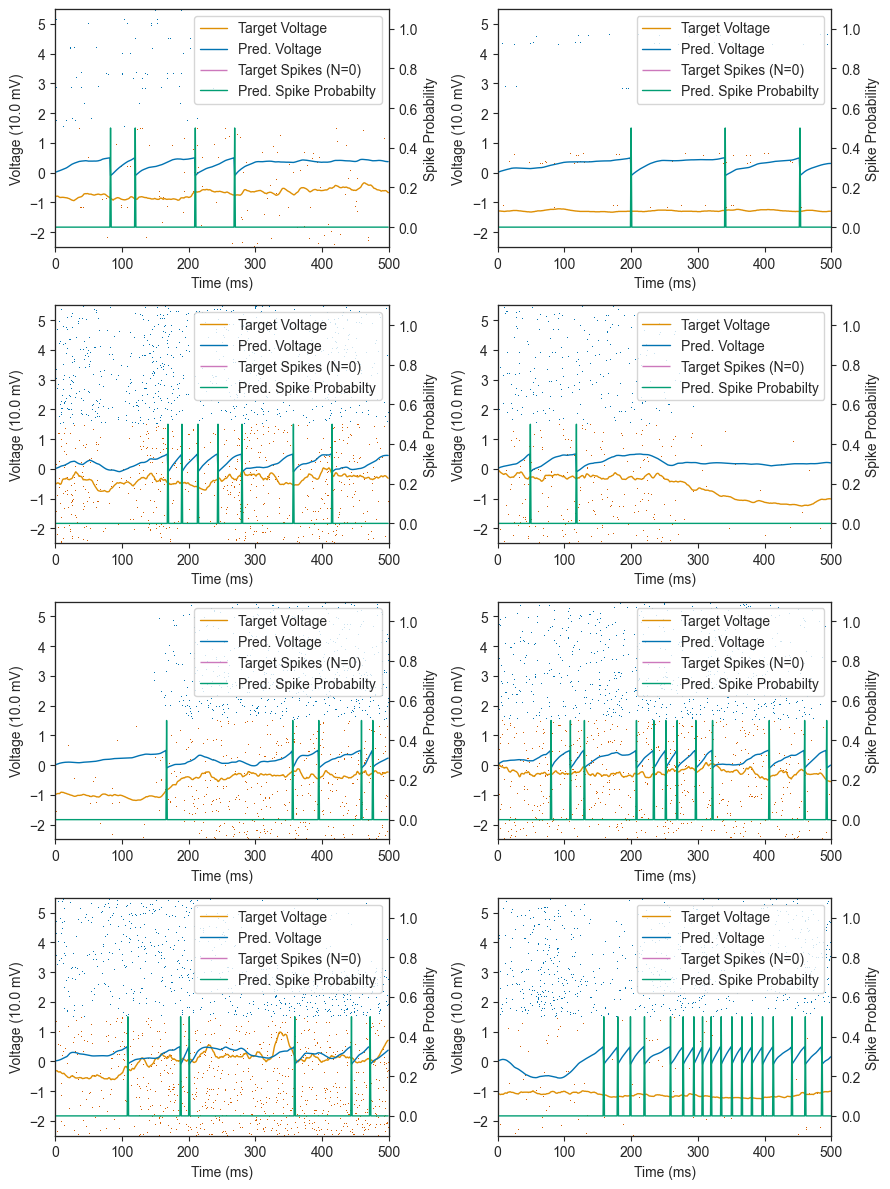

In [99]:
visualize_LIF_batch(X_viz, y_spike_viz, y_soma_viz, spikes/2, LIF, num_viz=8)

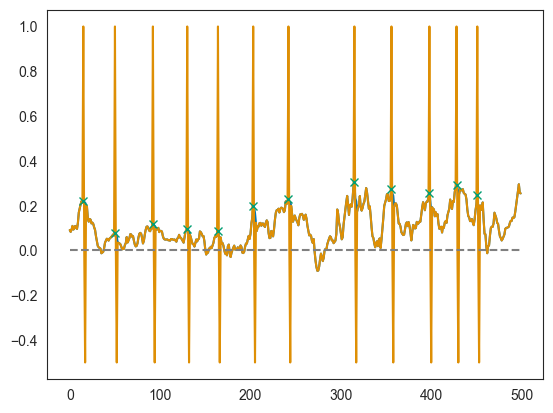

In [18]:
target = extract_spikes(outputs, visualize=True)

## Initialize training

In [31]:
model.train()
MSELoss = nn.MSELoss()
###set readout trainable
###train towards
running_loss = 0.0
values=torch.tensor([0.]).to(torch_device)
pbar = tqdm(
    enumerate(train_data_loader, 0),
    total=1000,#train_config["batches_per_epoch"],
    disable=not general_config["verbose"],
)
for i, data in pbar:
    inputs, _ = data
    
    # Perform a single training step
    init_optimizer.zero_grad()
    outputs = model(inputs)
    target_spikes = torch.from_numpy(extract_spikes(outputs)).to(torch_device).float()
    #loss = MSELoss(torch.heaviside(outputs, values), target_spikes.unsqueeze(-1))
    loss = MSELoss(outputs, target_spikes.unsqueeze(-1))# + MSELoss(outputs.mean(), target_spikes.unsqueeze(-1))
    loss.backward()
    init_optimizer.step()

    # Update running loss
    running_loss += loss.item()
    #pbar.set_description(f"Epoch {epoch+1} Loss: {running_loss / (i+1):.5f}")

  0%|▍                                                                                | 5/1000 [00:03<11:44,  1.41it/s]


IndexError: index 500 is out of bounds for axis 0 with size 500

In [ ]:
model.train()
MSELoss = nn.MSELoss()
###set readout trainable
###train towards
running_loss = 0.0
values=torch.tensor([0.]).to(torch_device)
pbar = tqdm(
    enumerate(train_data_loader, 0),
    total=1000,#train_config["batches_per_epoch"],
    disable=not general_config["verbose"],
)
for i, data in pbar:
    inputs, _ = data
    
    # Perform a single training step
    init_optimizer.zero_grad()
    outputs = model(inputs)
    target_spikes = torch.from_numpy(extract_spikes(outputs)).to(torch_device).float()
    #loss = MSELoss(torch.heaviside(outputs, values), target_spikes.unsqueeze(-1))
    loss = MSELoss(outputs, target_spikes.unsqueeze(-1))# + MSELoss(outputs.mean(), target_spikes.unsqueeze(-1))
    loss.backward()
    init_optimizer.step()

    # Update running loss
    running_loss += loss.item()
    #pbar.set_description(f"Epoch {epoch+1} Loss: {running_loss / (i+1):.5f}")

## Training

In [ ]:
# Initialize the best validation RMSE to a high value
best_valid_rmse = float('inf')
best_model_state_dict = model.state_dict().copy()

# Training loop
train_rmse_hist = []
train_auc_hist = []
valid_rmse_hist = []
valid_auc_hist = []
for epoch in range(train_config["num_epochs"]):
    # Training
    model.train()
    running_loss = 0.0
    pbar = tqdm(
        enumerate(train_data_loader, 0),
        total=train_config["batches_per_epoch"],
        disable=not general_config["verbose"],
    )
    for i, data in pbar:
        inputs, targets = data
        
        # Perform a single training step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update running loss
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {running_loss / (i+1):.5f}")
    
    model.eval()
    with torch.no_grad():
        # Evaluate on training data
        train_eval_metrics = train_evaluator.evaluate(model)
        train_rmse = train_eval_metrics["soma_RMSE"]
        train_auc = train_eval_metrics["AUC"]
        train_rmse_hist.append(train_rmse)
        train_auc_hist.append(train_auc)

        # Evaluate on validation data
        valid_eval_metrics = valid_evaluator.evaluate(model)
        valid_rmse = valid_eval_metrics["soma_RMSE"]
        valid_auc = valid_eval_metrics["AUC"]
        valid_rmse_hist.append(valid_rmse)
        valid_auc_hist.append(valid_auc)

    # Copy model state dict if validation RMSE has improved
    if valid_rmse < best_valid_rmse:
        best_valid_rmse = valid_rmse
        best_model_state_dict = model.state_dict().copy()

    # Print statistics
    print(
        f'Epoch: {epoch+1}, '
        f'Train Loss: {running_loss / train_config["batches_per_epoch"]:.5f}, '
        f'Train RMSE: {train_rmse:.5f}, Train AUC: {train_auc:.5f}, '
        f'Valid RMSE: {valid_rmse:.5f}, Valid AUC: {valid_auc:.5f}'
    )

# Free up memory
del train_data_loader
gc.collect()

# Load the best model for evaluation
model.load_state_dict(best_model_state_dict)
model.eval();

## Evaluation

In [ ]:
# Visualize predictions
with torch.no_grad():
    outputs = model.neuronio_eval_forward(X_viz)
    visualize_training_batch(X_viz, y_spike_viz, y_soma_viz, outputs[..., 0], outputs[..., 1], num_viz=8)

In [15]:
# Gather all evaluation metrics
with torch.no_grad():
    if not general_config["short_training_run"]:
        random.seed(general_config["seed"])
        select_train_files = random.choices(train_files, k=10)
        train_predictions = compute_test_predictions_multiple_sim_files(
            neuron=model,
            test_files=select_train_files,
            burn_in_time=train_config["burn_in_time"],
            input_window_size=train_config["input_window_size"],
            device=torch_device,
        )
        train_results = filter_and_extract_core_results(*train_predictions, verbose=False)

        valid_predictions = compute_test_predictions_multiple_sim_files(
            neuron=model,
            test_files=valid_files,
            burn_in_time=train_config["burn_in_time"],
            input_window_size=train_config["input_window_size"],
            device=torch_device,
        )
        valid_results = filter_and_extract_core_results(*valid_predictions, verbose=False)

    test_predictions = compute_test_predictions_multiple_sim_files(
        neuron=model,
        test_files=test_files,
        burn_in_time=train_config["burn_in_time"],
        input_window_size=train_config["input_window_size"],
        device=torch_device,
    )
    test_results = filter_and_extract_core_results(*test_predictions, verbose=False)

eval_results = dict()
if not general_config["short_training_run"]:
    eval_results["train_results"] = train_results
    eval_results["valid_results"] = valid_results
eval_results["test_results"] = test_results

In [16]:
# Show evaluation results
eval_results

{'test_results': {'TP @ 0.0025 FP': np.float64(0.10267034990791897),
  'AUC @ 0.0025 FP': np.float64(0.049263351749539594),
  'TP @ 0.0100 FP': np.float64(0.3893492940454266),
  'AUC @ 0.0100 FP': np.float64(0.20136227667736978),
  'AUC': np.float64(0.9589877930046388),
  'soma_explained_variance_percent': 87.73050802655531,
  'soma_RMSE': np.float64(1.074095794870259),
  'soma_MAE': 0.683903419814988}}